<a href="https://colab.research.google.com/github/StevenAlvaradoAguilar/Codigo_Clases_IA/blob/main/Clase_12_CRNN_with_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis del problema

La clasificación temporal conexionista (CTC) es un tipo de salida de red neuronal útil para abordar problemas de secuencia como escritura a mano y reconocimiento de voz donde el tiempo varía. El uso de CTC garantiza que no se necesita un conjunto de datos alineado, lo que hace que el proceso de capacitación sea más sencillo.

![To generate text the model's output is fed back to the input](https://sid2697.github.io/Blog_Sid/assets/images/CTC_1.png)

## Importar librerias

In [ ]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt  
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Bidirectional, LSTM
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import cv2
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

print( 'TensorFlow Version:', tf.__version__ )
print( 'Keras Version:', tf.keras.__version__ ) 

TensorFlow Version: 2.12.0
Keras Version: 2.12.0


In [ ]:
from google.colab import drive
drive.mount( '/content/gdrive' )

Mounted at /content/gdrive


# Carga de datos

In [ ]:
os.chdir( r"/content/gdrive/My Drive" )
if not os.path.isdir( r"CRNN_with_CTC_Loss" ):     
    print( 'Downloading the Captcha images dataset ...' )
    !pip install patool
    import patoolib
    import glob
    # Clone a GitHub repository to our Google Drive
    !git clone https://github.com/YenLinWu/CRNN_with_CTC_Loss.git     
    # Unzip the file with filename contains '.rar'
    rar = glob.glob( r"CRNN_with_CTC_Loss/*.rar" )
    for i in range(len(rar)):
        patoolib.extract_archive( rar[i], outdir=r"/content/gdrive/My Drive" )

else: print( 'Captcha images dataset is ready.' )

Captcha images dataset is ready.


In [ ]:
# Path to the dataset directory
CaptchaImages = r"/content/gdrive/My Drive/CaptchaImages"
data_dir = Path( CaptchaImages )

print( 'Working directory:', data_dir )

Working directory: /content/gdrive/My Drive/CaptchaImages


In [ ]:
# Get list of all the captcha images
Images = sorted( list(map(str, list(data_dir.glob('*.png')))) )
Labels = [ img.split(os.path.sep)[-1].split(".png")[0] for img in Images ]
Characters = set( char for label in Labels for char in label )
Image_Height = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[0] for img_path in Images )
Image_Width = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[1] for img_path in Images )

# Maximum length of any captcha in the dataset
Max_Length = max([ len(label) for label in Labels ])

print( 'Number of images found: ', len(Images) )
print( 'Number of labels found: ', len(Labels), '\n' )
print( 'Width of any captcha image:', next(iter(Image_Width)) )
print( 'Height of any captcha image:', next(iter(Image_Height)) )
print( 'Characters present: ', Characters ) 
print( 'Number of unique characters: ', len(Characters) )
print( 'Maxium length of any captcha image: ', Max_Length )

Number of images found:  1800
Number of labels found:  1800 

Width of any captcha image: 104
Height of any captcha image: 24
Characters present:  {'6', '8', '2', '1', '5', '9', '7', '3', '4', '0'}
Number of unique characters:  10
Maxium length of any captcha image:  4


### Parametros

In [ ]:
# Desired image dimensions where img_width % 4==0 and img_hight % 16==0 
img_width = 104
img_height = 32

# Number of passes of the entire training set the algorithm has completed
Epochs = 50

# Number of each batch
Batch_Size = 32

# Early Stopping
Early_Stopping_Patience = 10 
Min_Delta = 0.0001

# Preparacion de los datos

In [ ]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(Characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [ ]:
def encode_single_sample( img_path, label ):
    # 1. Read image
    img = tf.io.read_file( img_path )
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png( img, channels=1 )
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype( img, tf.float32 )
    # 4. Resize to the desired size
    img = tf.image.resize( img, [img_height,img_width] )
    # 5. Transpose the image because we want the time dimension to correspond to the width of the image, 
    #    i.e., shape = (img_weight,img_height,1).
    img = tf.transpose( img, perm=[1,0,2] )
    # 6. Map the characters in label to numbers
    label = char_to_num( tf.strings.unicode_split(label, input_encoding='UTF-8') )
    # 7. Return a dict as our model is expecting two inputs
    return { "Input": img, "Label": label }

#### CREAR MUESTRAS Y LOTES DE ENTRENAMIENTO

In [ ]:
# Splitting dataset into training and validation sets
def split_data( Images, Labels, train_size=0.9, shuffle=True ):
    # 1. Get the total amount of the dataset
    size = len( Images )
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.seed(42) 
        np.random.shuffle( indices )
    # 3. Get the size of training samples
    train_samples = int( size*train_size )
    # 4. Split data into training and validation sets
    x_train, y_train = Images[indices[:train_samples]], Labels[indices[:train_samples]]
    x_valid, y_valid = Images[indices[train_samples:]], Labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data( np.array(Images), np.array(Labels) )

In [ ]:
# Create training and valodation dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices( (x_train,y_train) )
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices( (x_valid,y_valid) )
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [ ]:
train_size=0.8
size = len( Images )
# 2. Make an indices array and shuffle it, if required
indices = np.arange( size )

np.random.seed(42) 
np.random.shuffle( indices )
# 3. Get the size of training samples
train_samples = int( size*train_size )

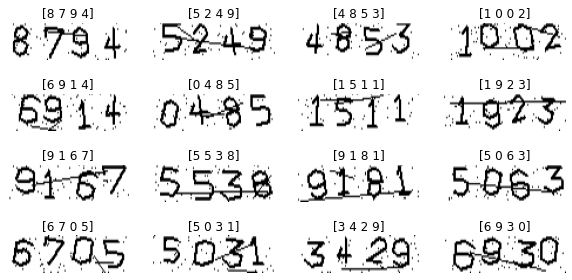

In [ ]:
# Visualize the Training Dataset
_, ax = plt.subplots( 4, 4, figsize=(10,5) )
for batch in train_dataset.take(1):
    images = batch['Input']
    labels = batch['Label']
    for i in range(16):
        img = ( images[i]*255 ).numpy().astype('uint8')
        ax[i // 4, i % 4].imshow( img[:, :, 0].T, cmap='gray' )
        ax[i // 4, i % 4].set_title(labels[i].numpy())
        ax[i // 4, i % 4].axis('off')
plt.show()

## Modelo de Deep Learning Convolutional Recurrent Neural Network(CRNN)

In [ ]:
# Build an endpoint layer for implementing CTC loss.
class CTCLayer( layers.Layer ):
    def __init__( self, name=None, **kwargs ):
        super().__init__( name=name )
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast( tf.shape(y_true)[0], dtype='int64' )
        input_length = tf.cast( tf.shape(y_pred)[1], dtype='int64' )
        label_length = tf.cast( tf.shape(y_true)[1], dtype='int64' )
        
        input_length = input_length*tf.ones( shape=(batch_len,1), dtype='int64' )
        label_length = label_length*tf.ones( shape=(batch_len,1), dtype='int64' )

        loss = self.loss_fn( y_true, y_pred, input_length, label_length )
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
def Build_Model():
    # Inputs to the model 
    input_tensor = Input( (img_width,img_height,1), dtype='float32', name='Input' )
    labels = Input( shape=(None,), dtype='float32', name="Label" )
    
    # First convolution block
    x = Conv2D( 64, (3,3), activation='relu', padding='same', name='Conv_1' )(input_tensor)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_1' )(x)
    
    # Second convolution block
    x = Conv2D( 128, (3,3), activation='relu', padding='same', name='Conv_2' )(x)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_2' )(x)
    
    # Third convolution block
    x = Conv2D( 256, (3,3), activation='relu', padding='same', name='Conv_3' )(x)
    x = BatchNormalization( name='BN_1' )(x)
    
    # Fourth convolution block
    x = Conv2D( 512, (3,3), activation='relu', padding='same', name='Conv_4' )(x)  
    x = MaxPooling2D( pool_size=(2,1), strides=2, name='MaxPooling_3' )(x)
    
    # Fifth convolution block
    x = Conv2D( 512, (2,2), activation='relu', name='Conv_5' )(x)
    
    # Reshape accordingly before passing the output to the RNN part of the model,
    # i.e., convert shape=(batch,feature_weight,feature_height,channel) to shape=(batch,feature_weight,channel*feature_height) 
    Conv_Shape = x.get_shape( )
    x = Reshape( target_shape=(int(Conv_Shape[1]),int(Conv_Shape[2]*Conv_Shape[3])), name='Reshape' )(x)
    x = Dense( 64, activation='relu', name='Dense' )(x)
    x = Dropout( 0.25, name='Dropout' )(x)

    # RNNs
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_1' )(x)
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_2' )(x)

    # Output layer
    x = Dense( len(Characters)+1, activation='softmax', name='Softmax' )(x) 

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer( name='CTC_Loss' )(labels, x)
    
    # Define the model
    model = Model( inputs=[input_tensor,labels], outputs=[output], name='CRNN_Model_with_CTC_LOSS' )    
    
    # Compile the model and return
    model.compile( optimizer=Adam() )
    
    return model

CRNN = Build_Model()
CRNN.summary()

Model: "CRNN_Model_with_CTC_LOSS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 104, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv_1 (Conv2D)                (None, 104, 32, 64)  640         ['Input[0][0]']                  
                                                                                                  
 MaxPooling_1 (MaxPooling2D)    (None, 52, 16, 64)   0           ['Conv_1[0][0]']                 
                                                                                                  
 Conv_2 (Conv2D)                (None, 52, 16, 128)  73856       ['MaxPooli

#### Callbacks

In [ ]:
# Model Check Point
Check_Point = ModelCheckpoint( 'CRNN.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )

In [ ]:
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )

#### Entrenar el modelo

In [ ]:
tf.config.run_functions_eagerly(True)
History = CRNN.fit( train_dataset, validation_data=validation_dataset, epochs=Epochs, 
                    callbacks=[ Check_Point, Early_Stopping ] )                      

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 11.0889
Epoch 1: val_loss improved from inf to 10.82516, saving model to CRNN.h5
51/51 [==============================] - 8s 161ms/step - loss: 11.0889 - val_loss: 10.8252
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 10.6567
Epoch 2: val_loss improved from 10.82516 to 10.75871, saving model to CRNN.h5
51/51 [==============================] - 8s 153ms/step - loss: 10.6567 - val_loss: 10.7587
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 10.6461
Epoch 3: val_loss improved from 10.75871 to 10.75741, saving model to CRNN.h5
51/51 [==============================] - 9s 177ms/step - loss: 10.6461 - val_loss: 10.7574
Epoch 4/50
51/51 [==============================] - ETA: 0s - loss: 10.3762
Epoch 4: val_loss did not improve from 10.75741
51/51 [==============================] - 8s 147ms/step - loss: 10.3762 - val_loss: 12.9095
Epoch 5/50
51/51 [==============================] - ETA

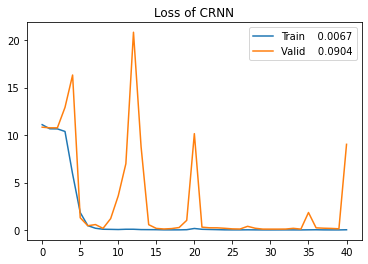

In [ ]:
Train_Loss = History.history['loss']
Val_Loss = History.history['val_loss']
epochs_range = range(Epochs)

plt.subplot( )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train'+"{:10.4f}".format( min(History.history['loss']) ) )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Valid'+"{:10.4f}".format( min(History.history['val_loss']) ) )
plt.legend( loc='upper right' )
plt.title( 'Loss of CRNN')
plt.show()

## Evaluacion

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = Model( CRNN.get_layer( name='Input' ).input, CRNN.get_layer( name='Softmax' ).output, name='Prediction' )
prediction_model.summary()

Model: "Prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 104, 32, 1)]      0         
                                                                 
 Conv_1 (Conv2D)             (None, 104, 32, 64)       640       
                                                                 
 MaxPooling_1 (MaxPooling2D)  (None, 52, 16, 64)       0         
                                                                 
 Conv_2 (Conv2D)             (None, 52, 16, 128)       73856     
                                                                 
 MaxPooling_2 (MaxPooling2D)  (None, 26, 8, 128)       0         
                                                                 
 Conv_3 (Conv2D)             (None, 26, 8, 256)        295168    
                                                                 
 BN_1 (BatchNormalization)   (None, 26, 8, 256)        1

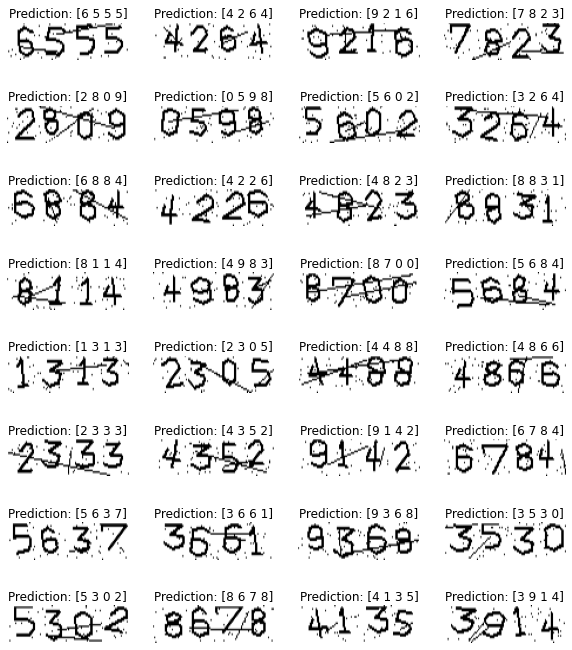

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:Max_Length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res =res.numpy()
        output_text.append(res)
    return output_text

#  Check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch['Input']
    batch_labels = batch['Label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

   
    _, ax = plt.subplots( 8, 4, figsize=(10,12) )
    for i in range(len(pred_texts)):
        img = ( batch_images[i, :, :, 0]*255).numpy().astype(np.uint8)
        img = img.T
        title = f'Prediction: {pred_texts[i]}'
        ax[i // 4, i % 4].imshow( img, cmap='gray' )
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()